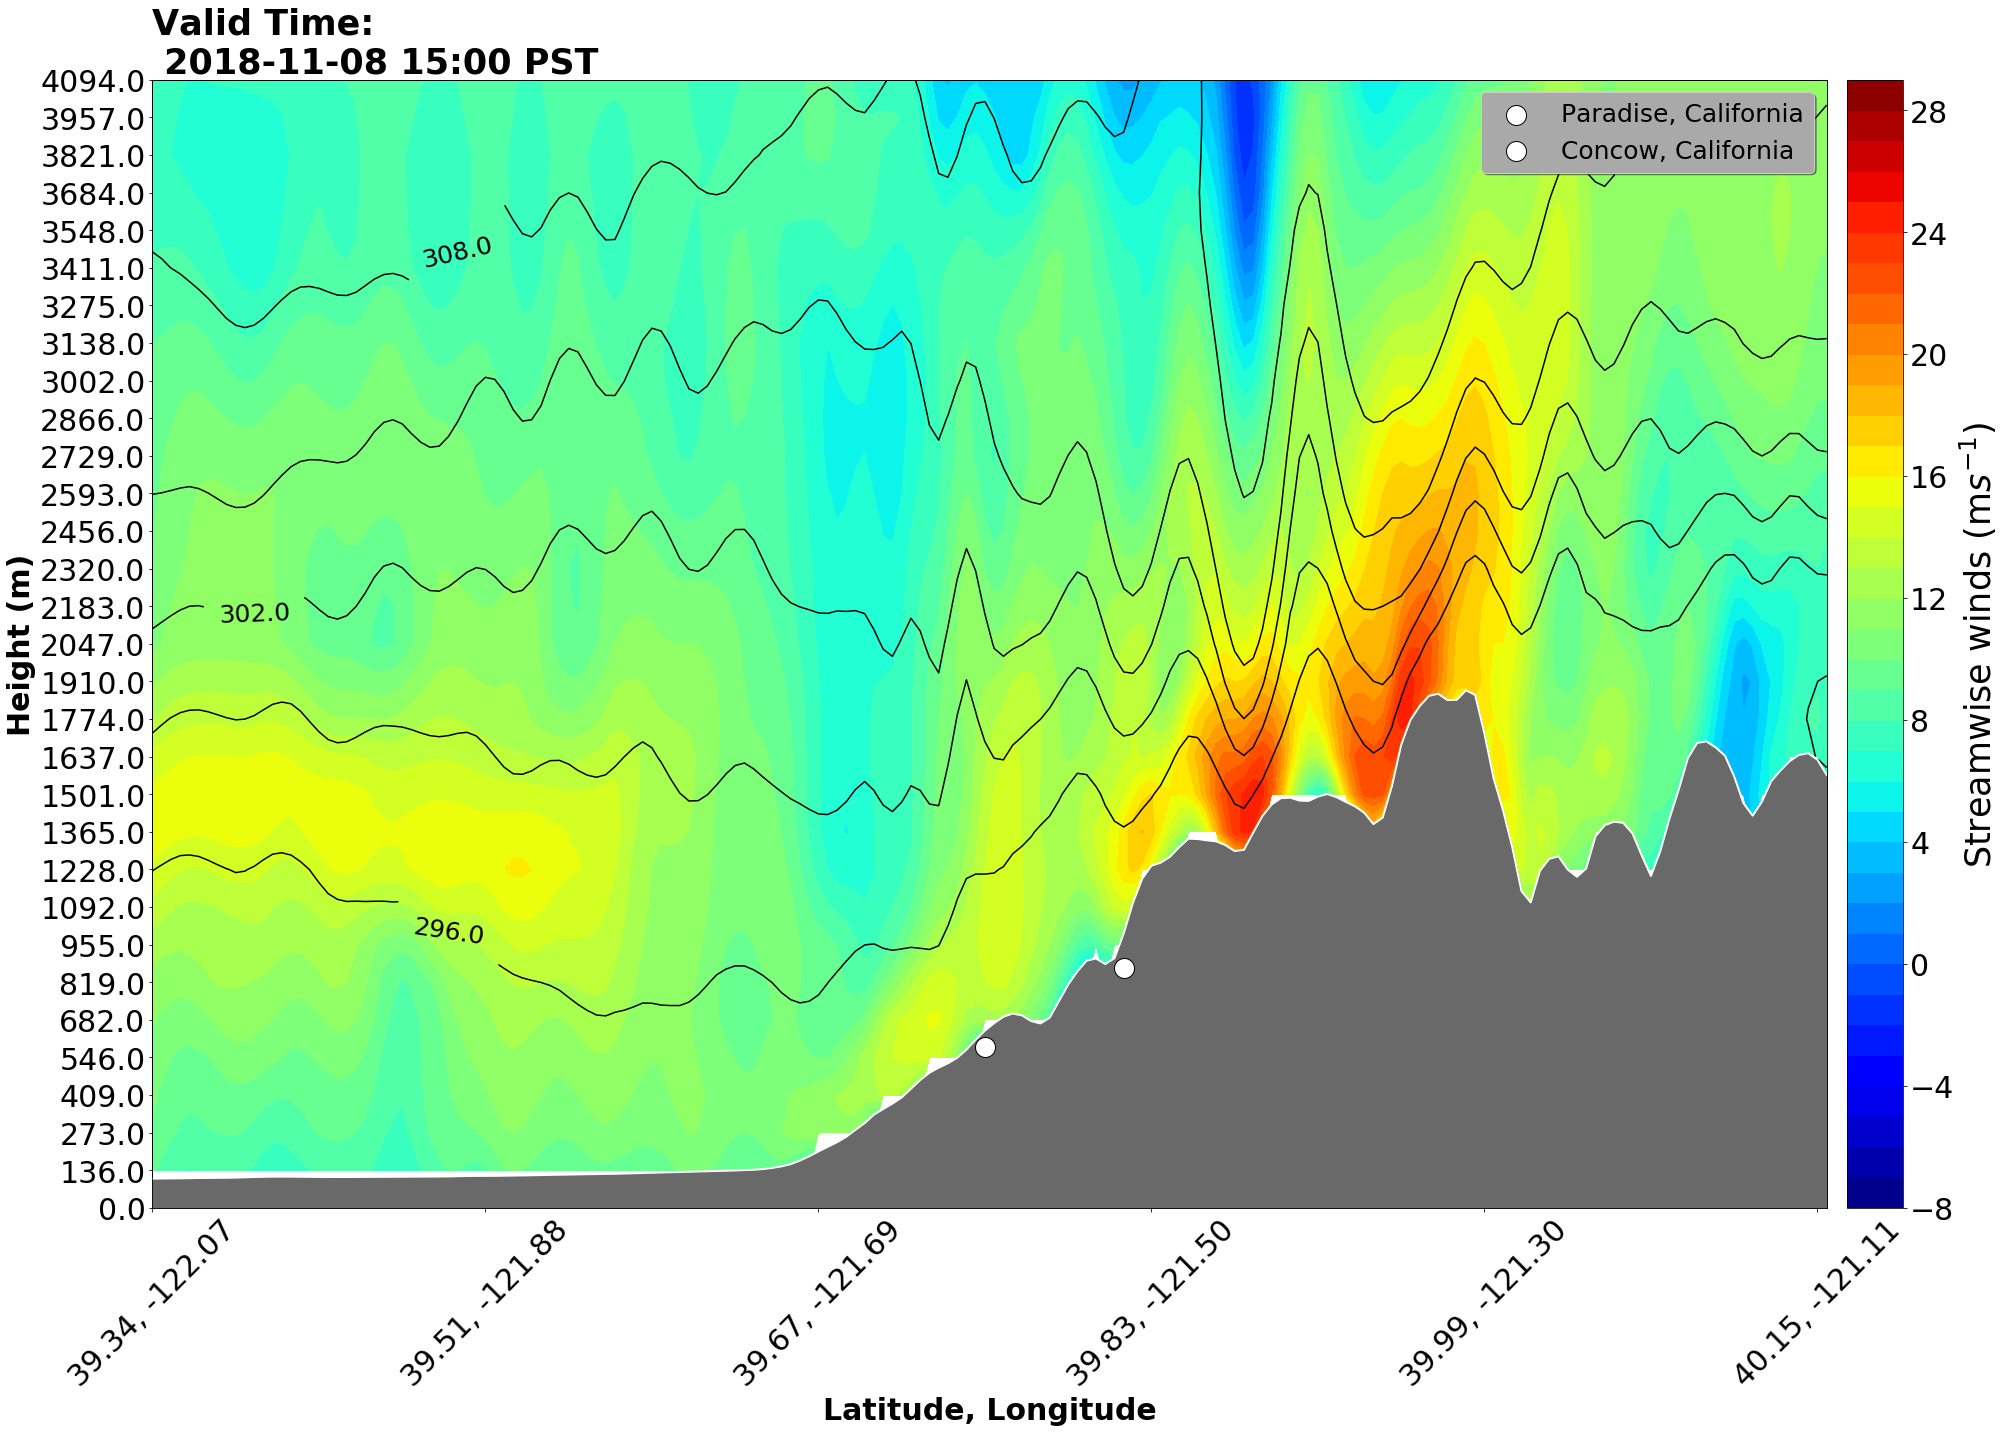

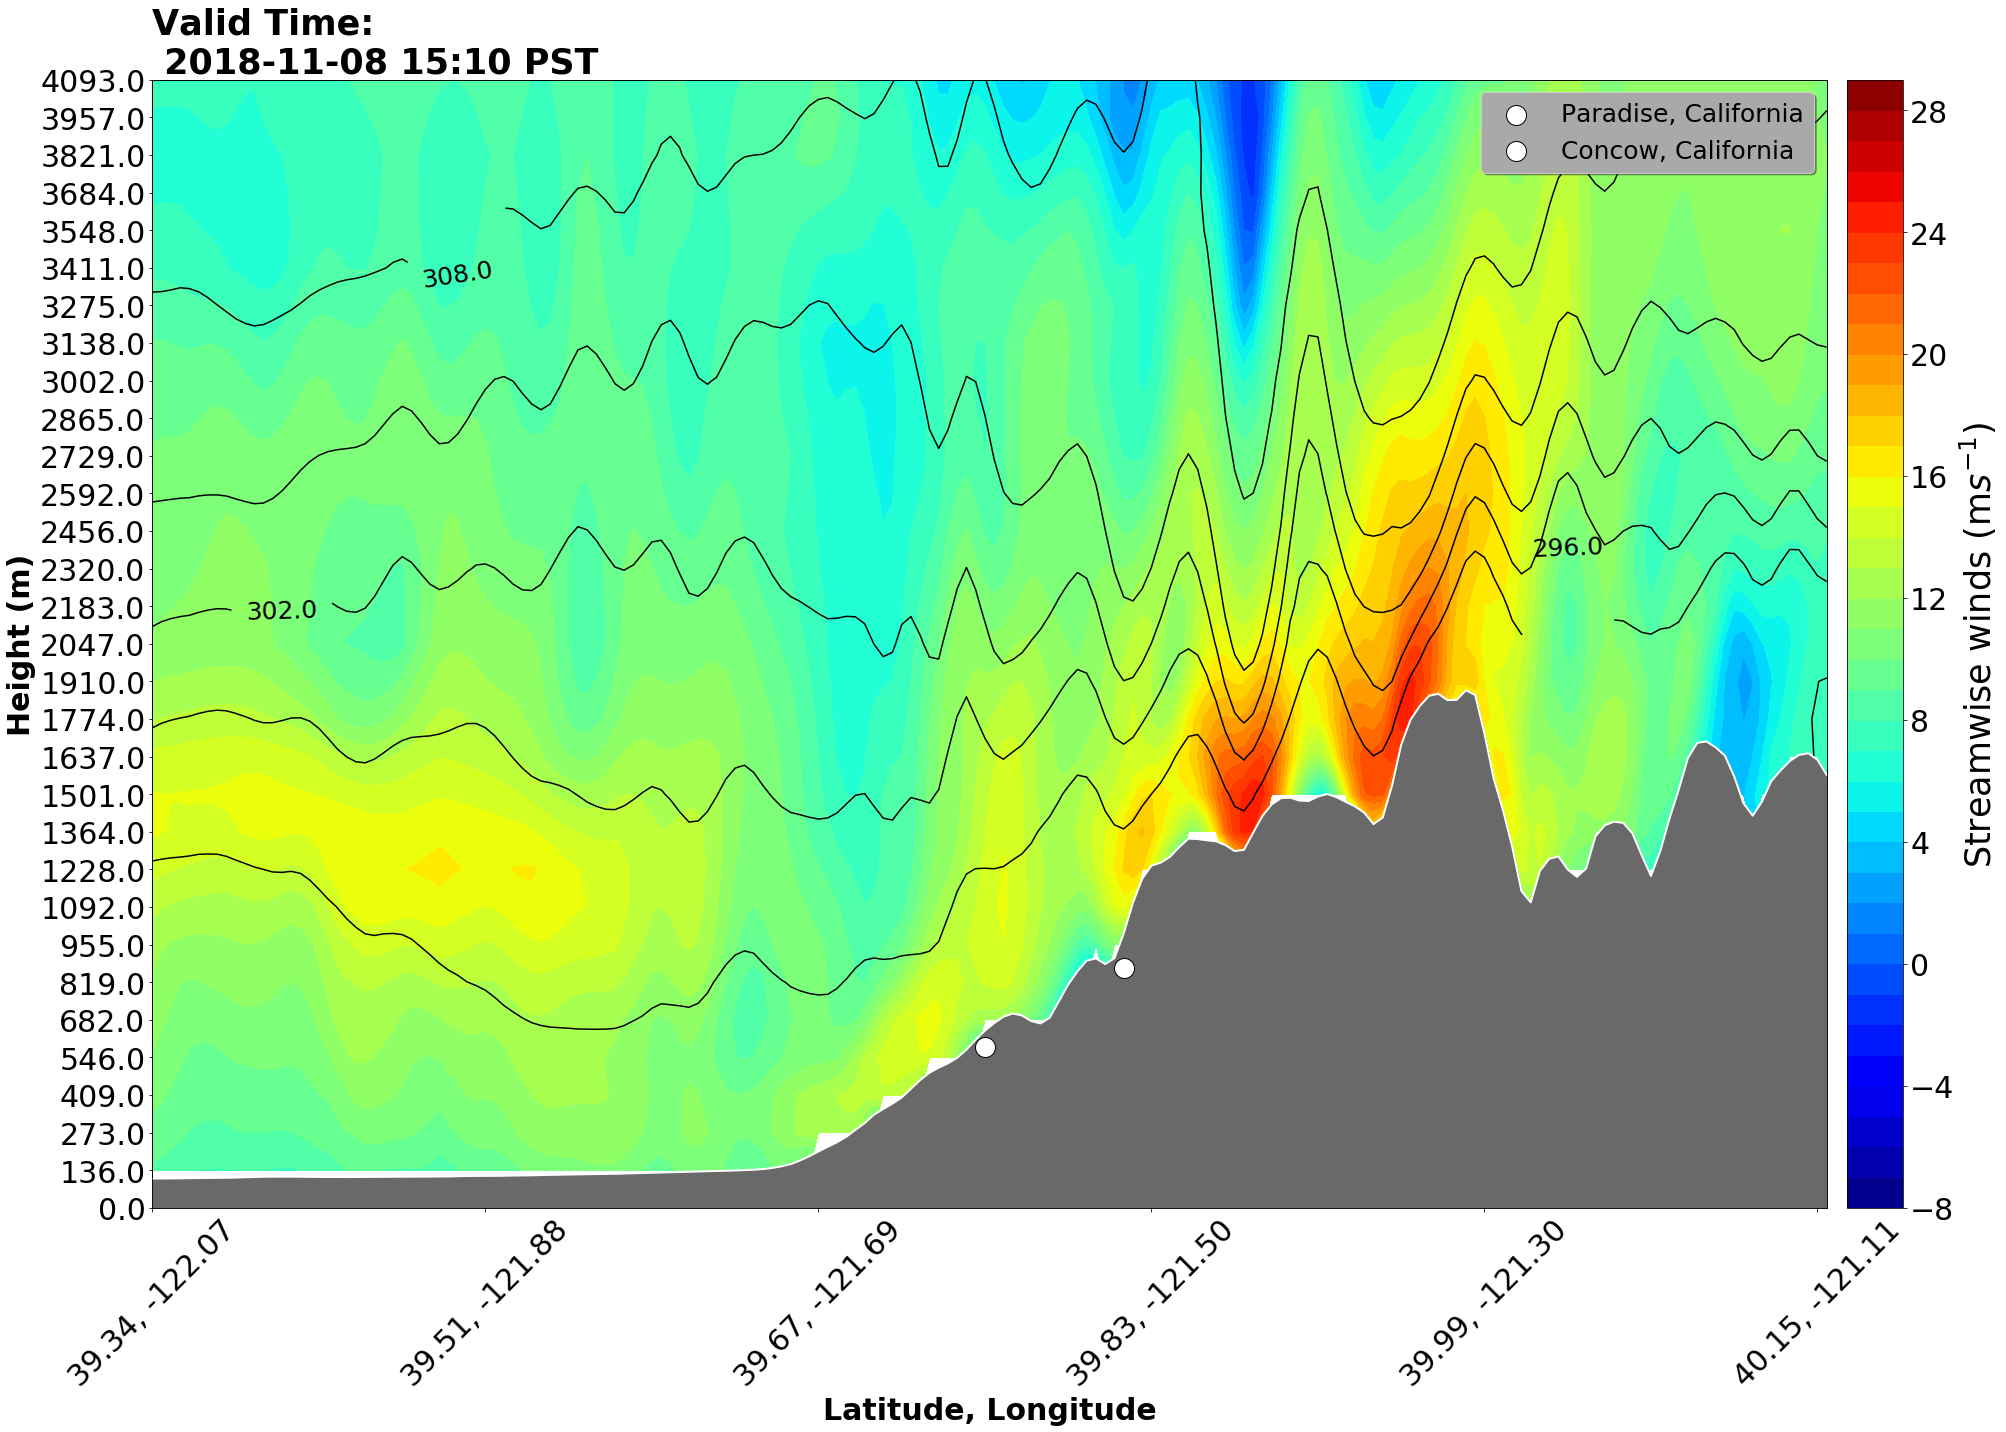

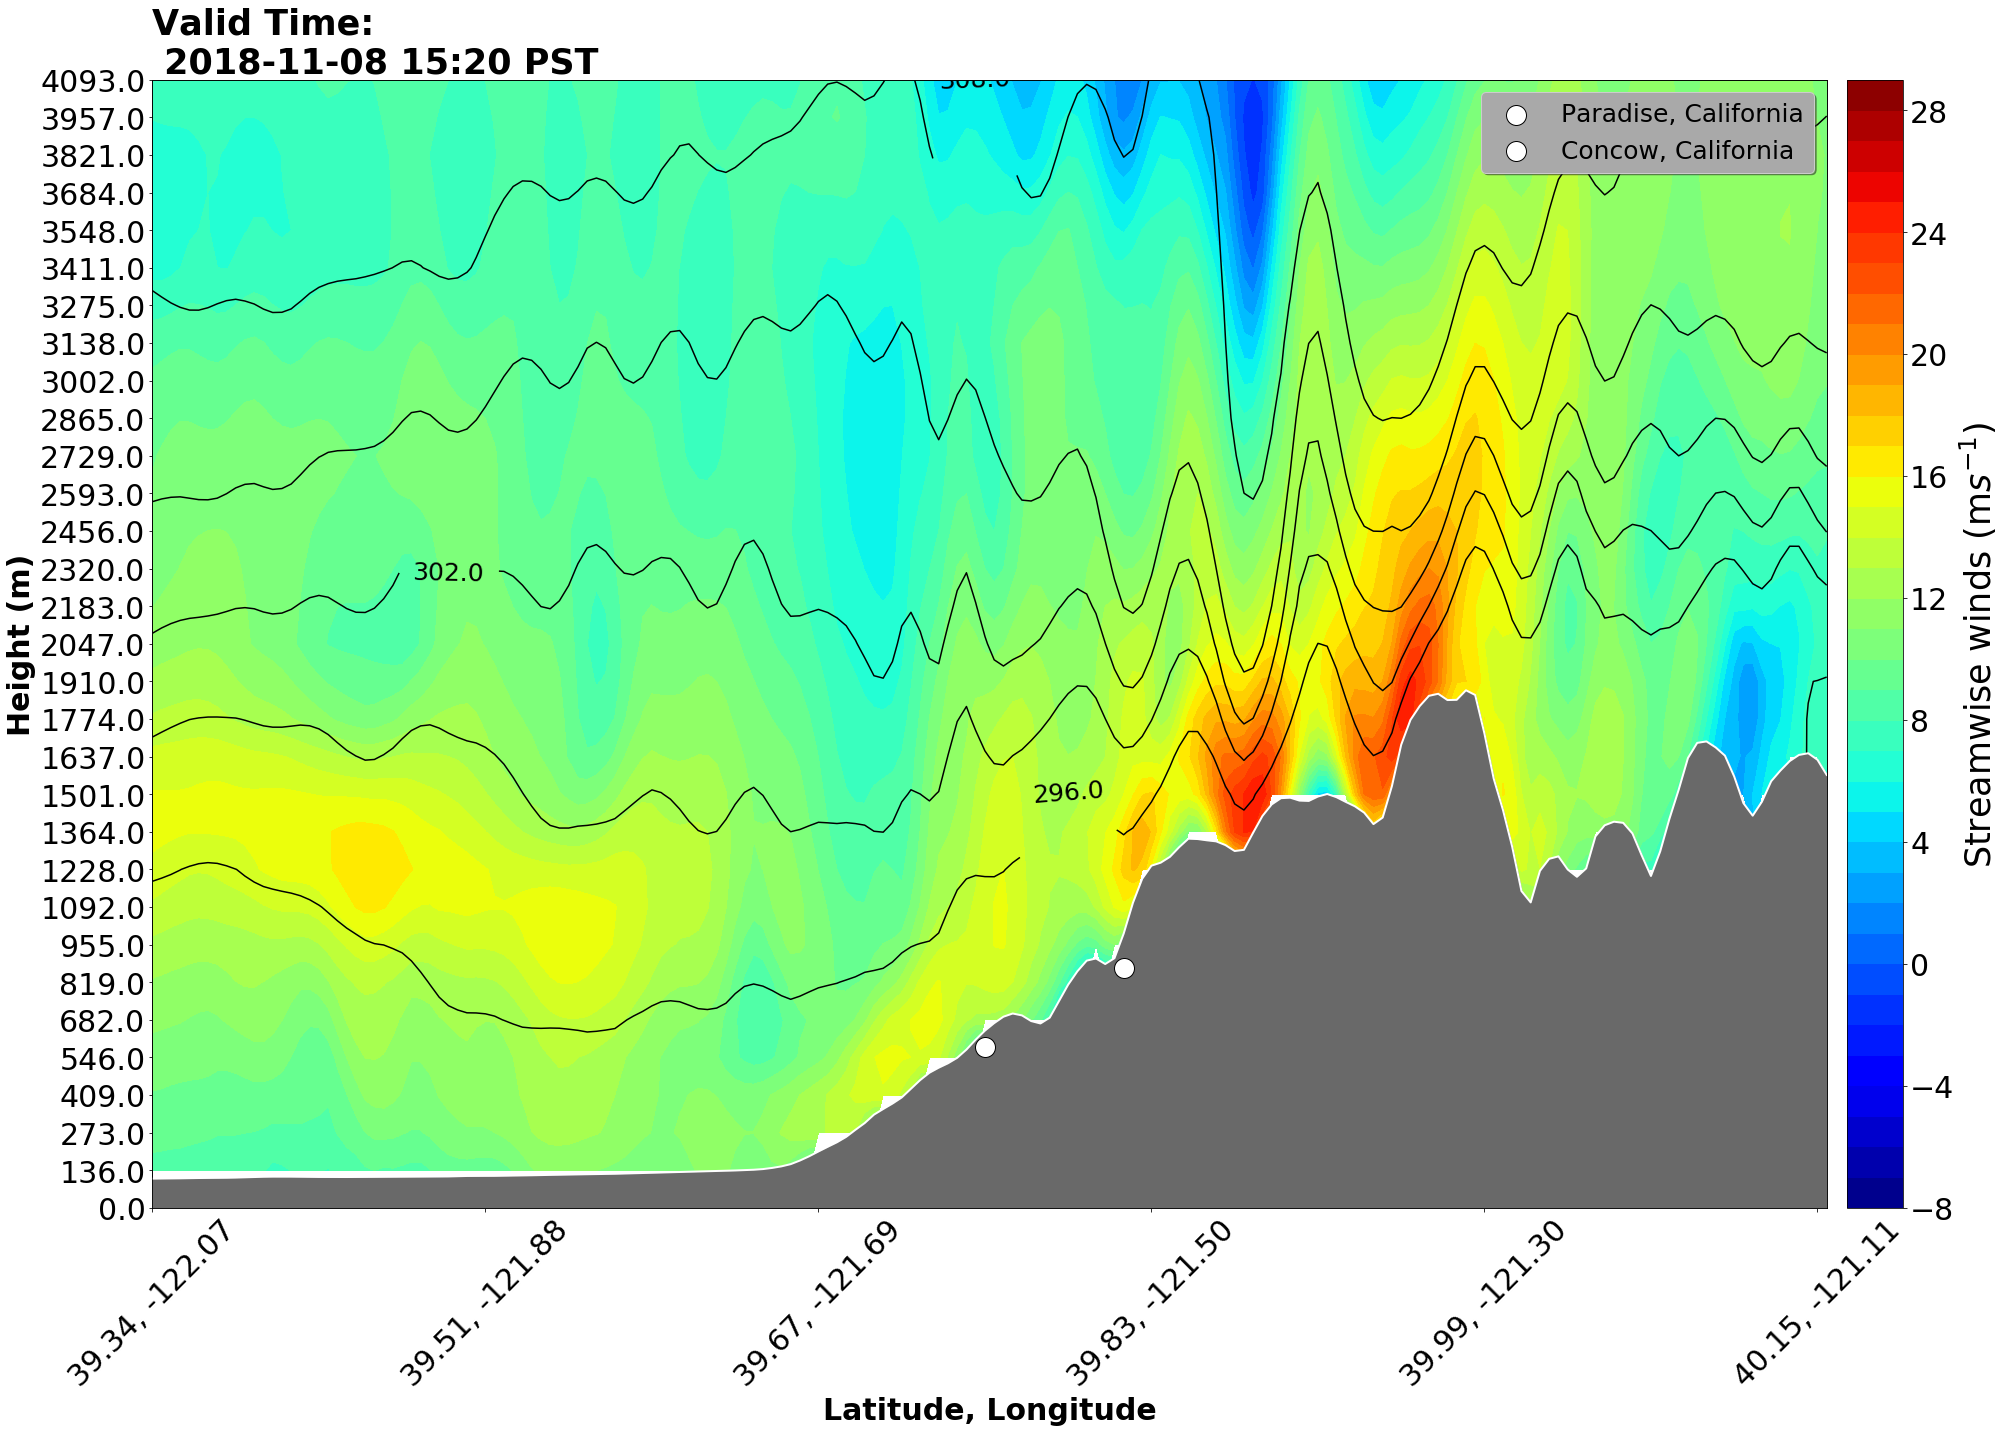

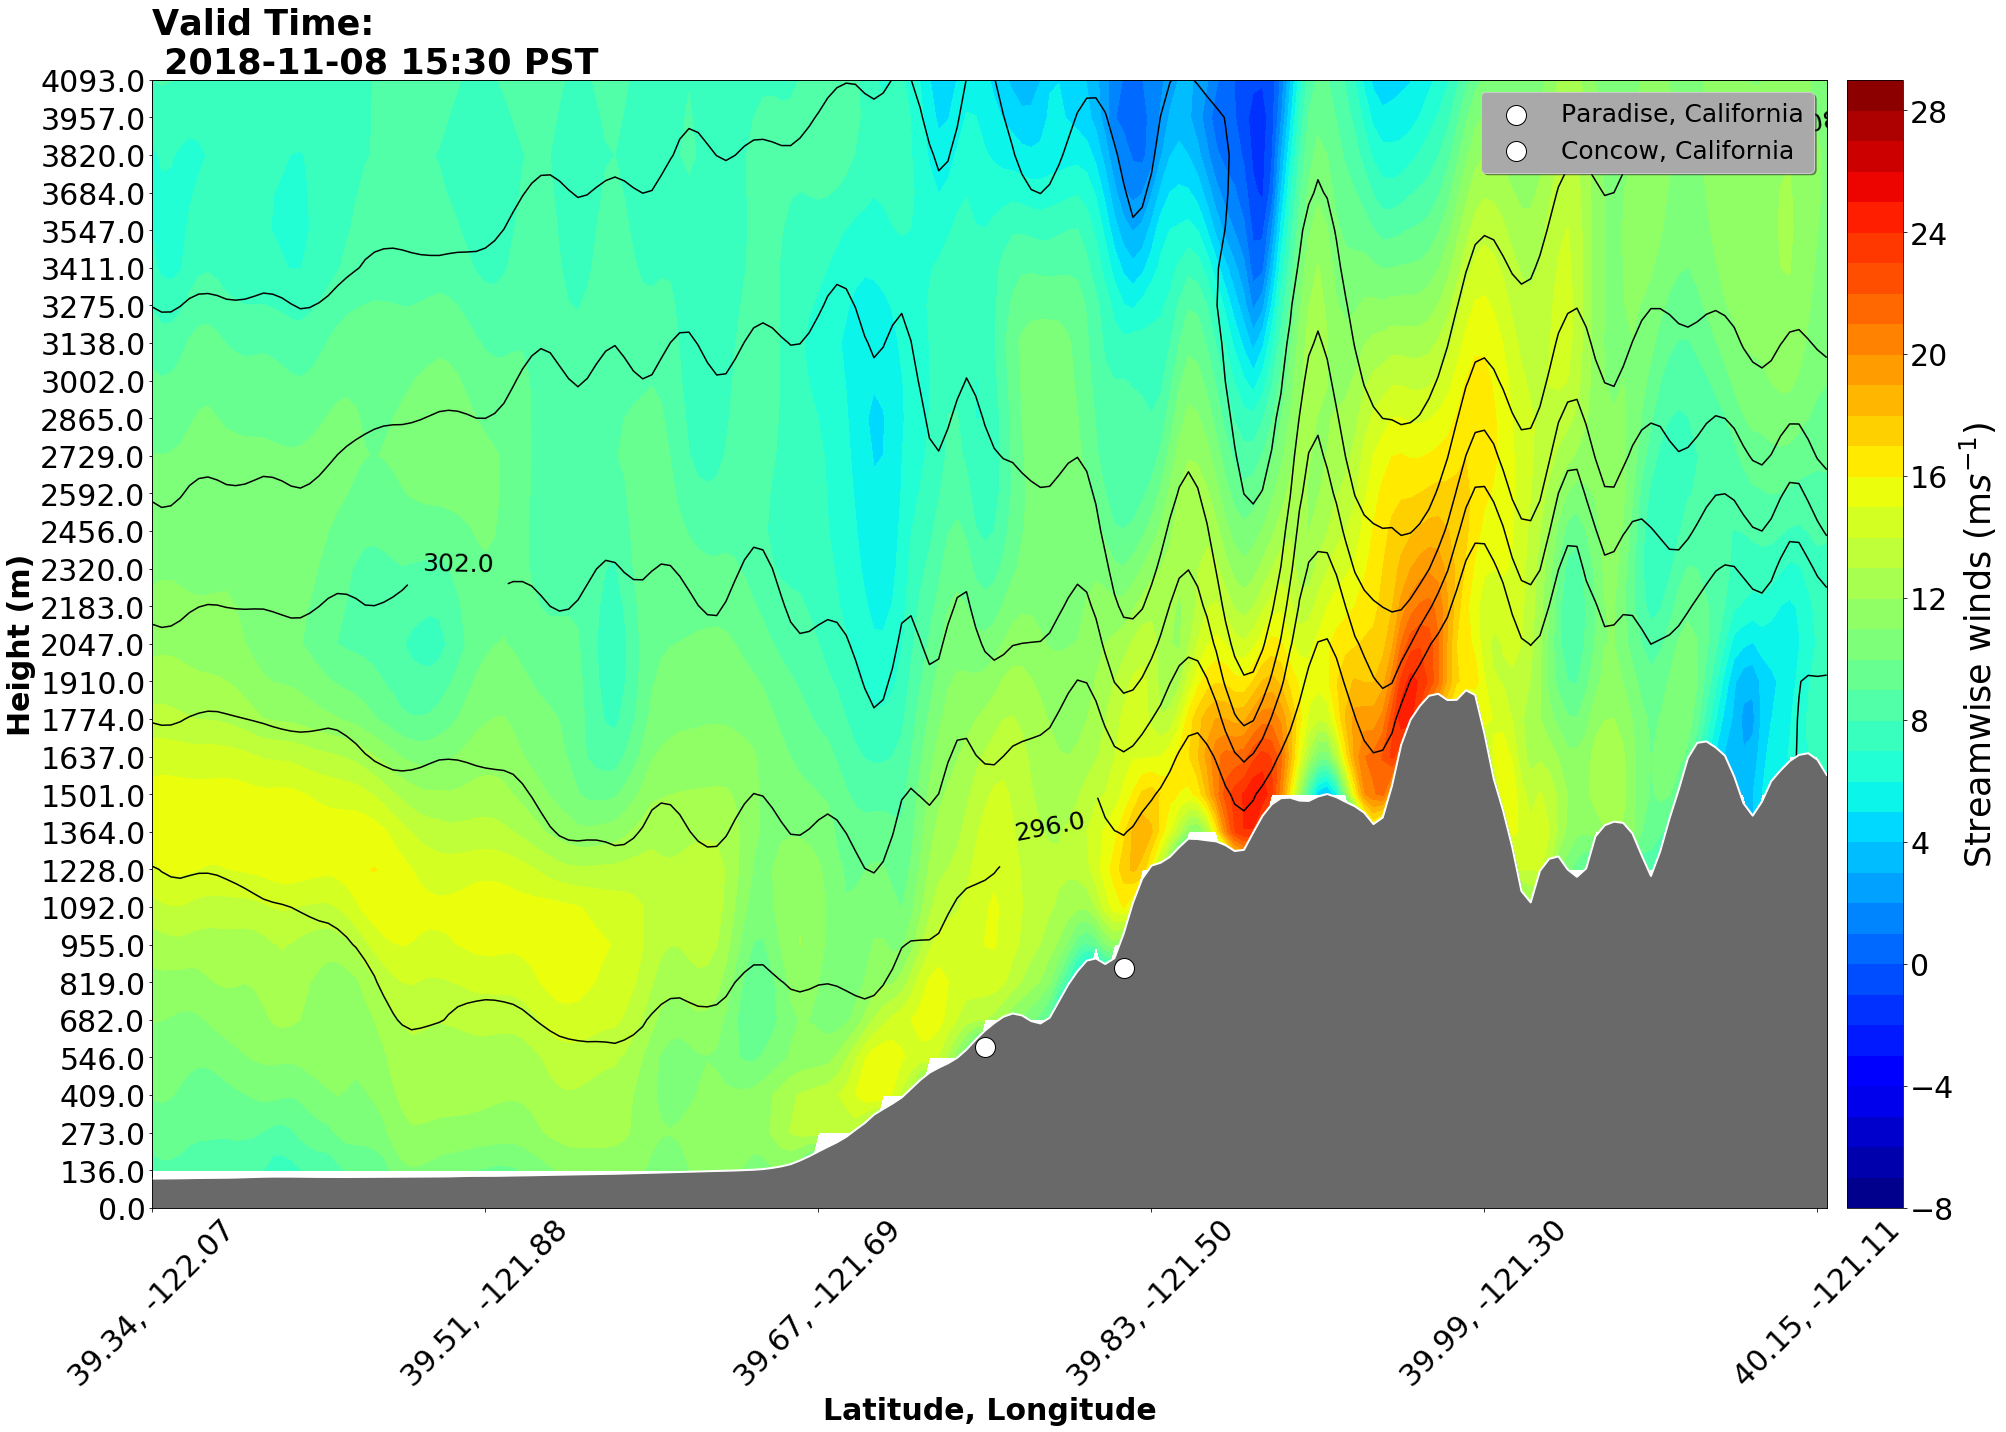

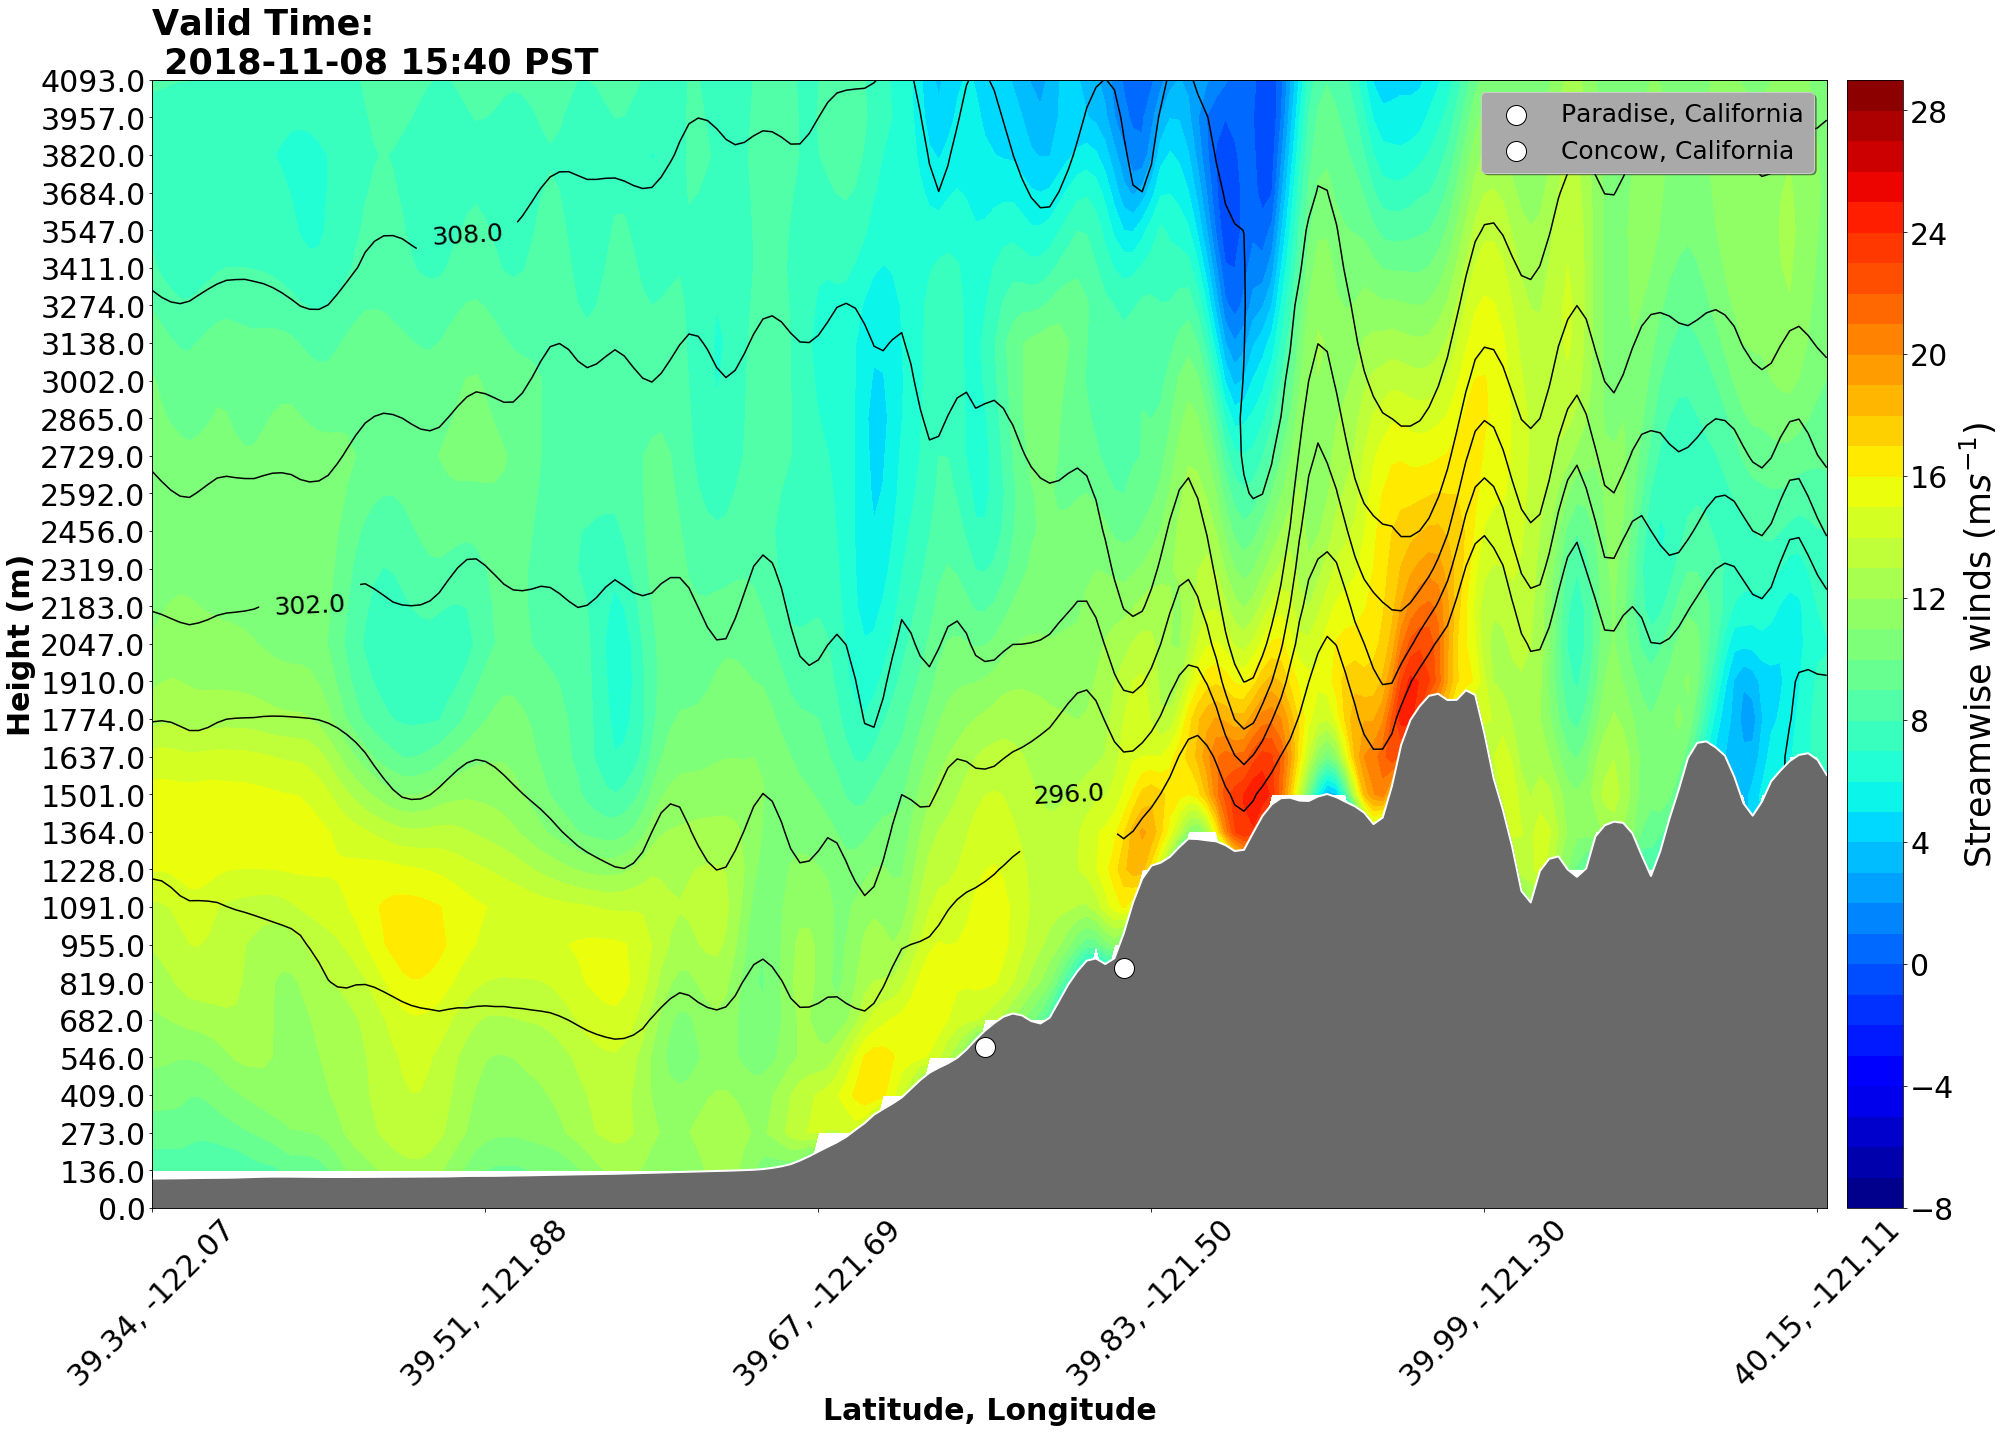

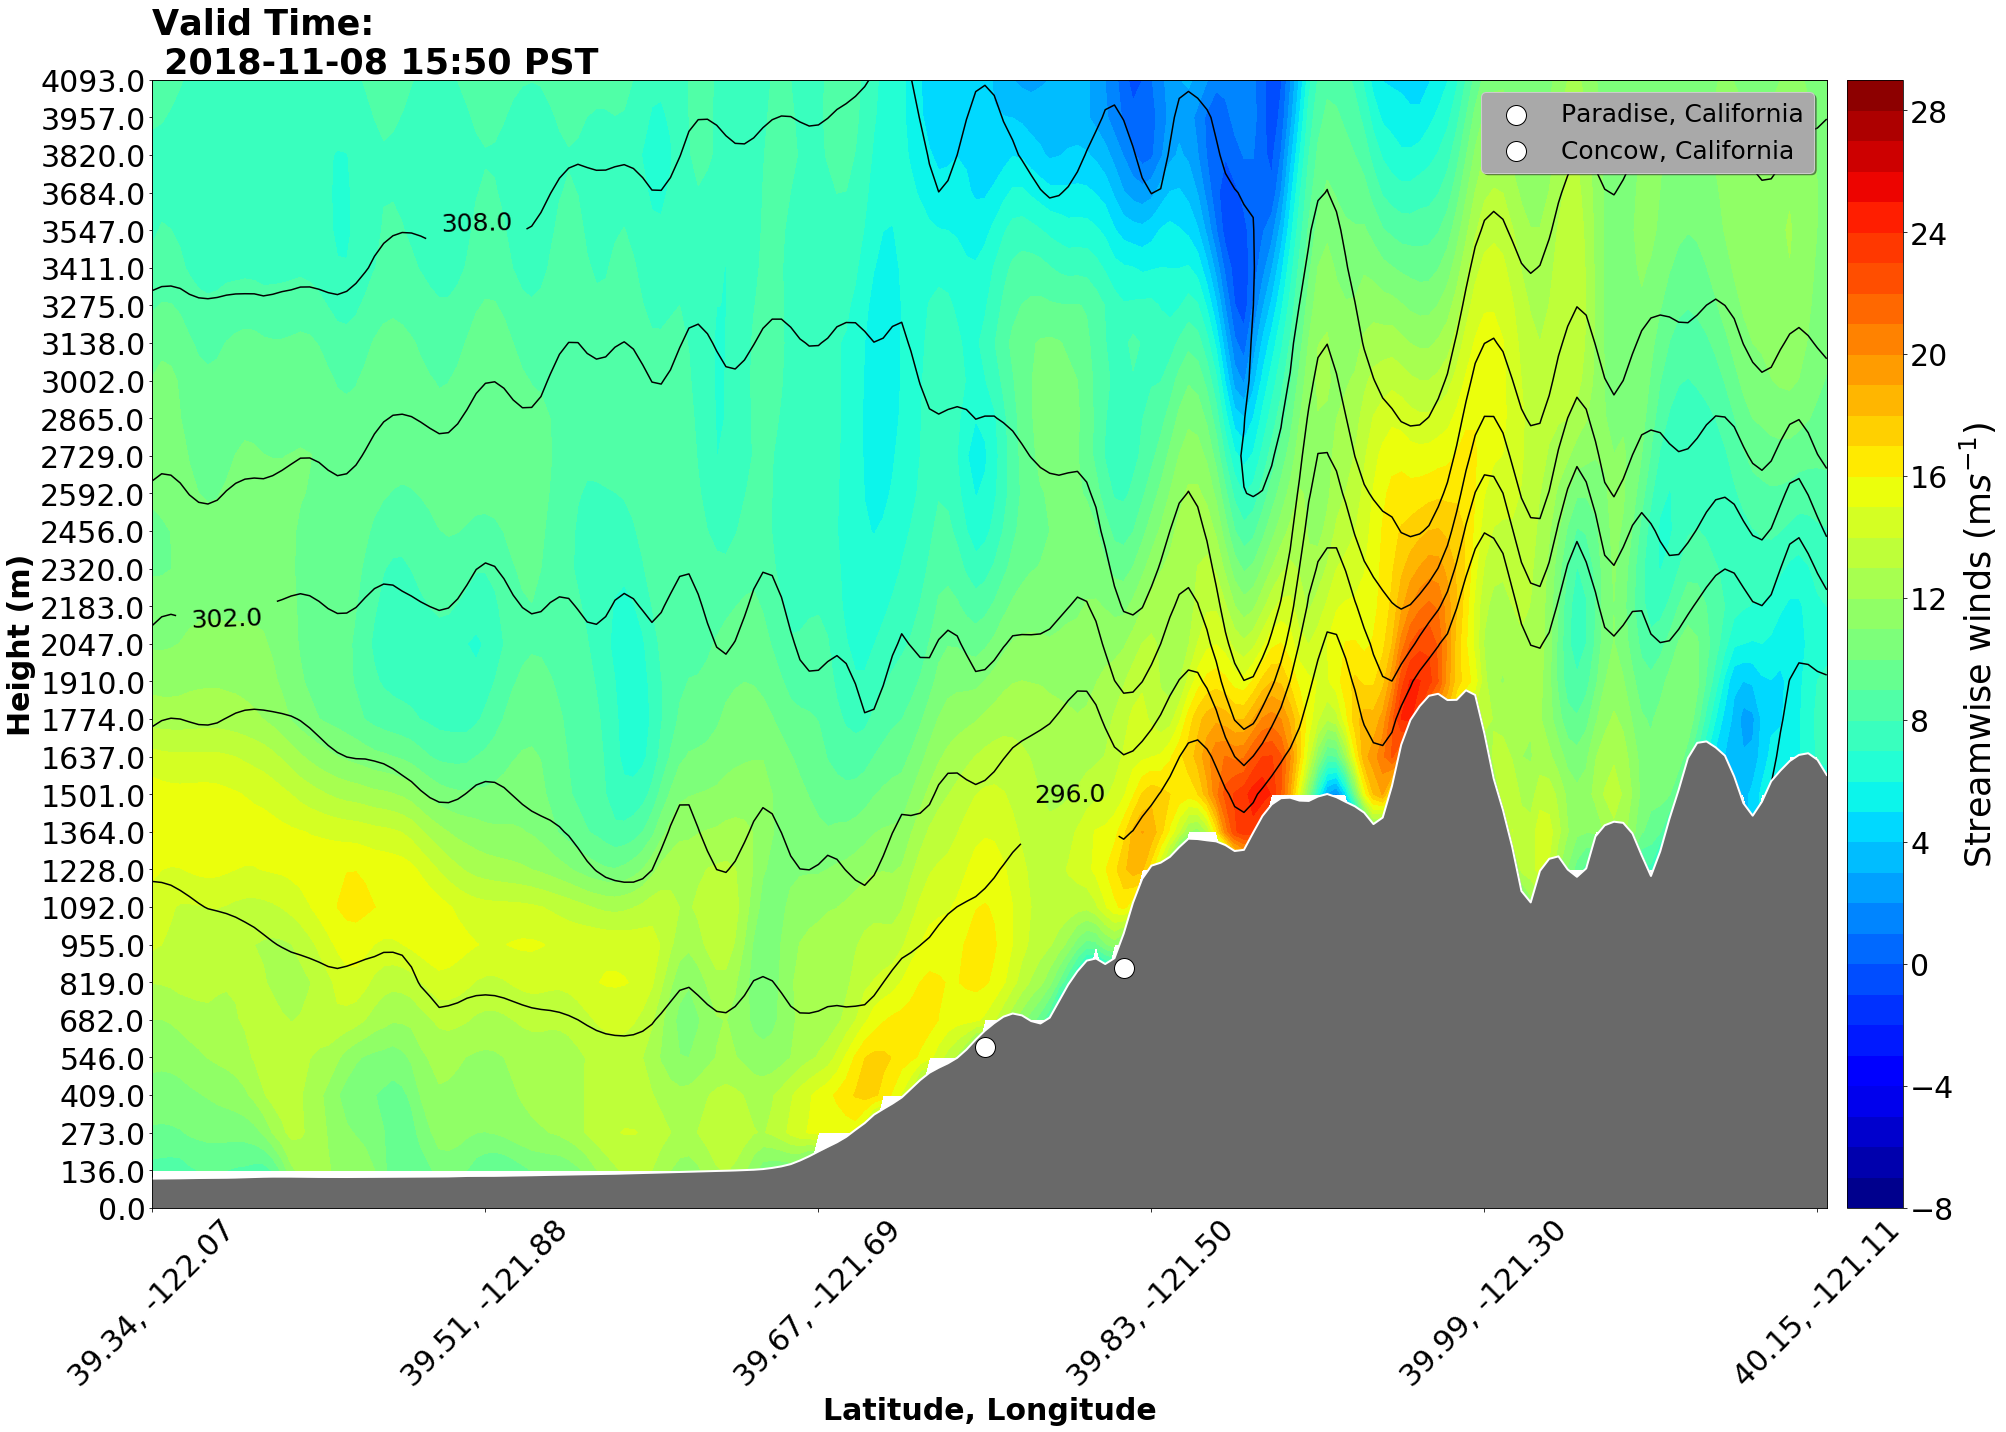

In [116]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import scipy.ndimage as ndimage
from wrf import(getvar,interplevel, to_np, latlon_coords, interpline, get_cartopy, cartopy_xlim, cartopy_ylim,ALL_TIMES, vertcross, smooth2d, CoordPair, GeoBounds)
from metpy.plots import USCOUNTIES
import metpy.calc as mpcalc
from metpy.units import units
import pandas as pd

############################################
#mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']
############################################


##### Funtiction used to calculate the Streamwise component of a wind from a specified angle
def streamwise(Ua,Va, deg = 30):
    
    """ Function used to calculated the streamwise component of the wind base off https://www.eol.ucar.edu/content/wind-direction-quick-reference
     deg
    """
    Ugeo=-1*np.sin(np.deg2rad(deg))
    Vgeo=-1*np.cos(np.deg2rad(deg))
    D=np.arctan2(Vgeo,Ugeo)
    Us=Ua*np.cos(D)+Va*np.sin(D)
    Vs=-Ua*np.sin(D)+Va*np.cos(D)
    return Us,Vs  


def t_ind(Time):
    
    """ Time = Local time
    input time sting in Y-m-d H:M:S format """
    ds_time = pd.to_datetime(time.data).tz_localize('UTC').tz_convert('US/Pacific')
    T = pd.to_datetime(Time, format = '%Y-%m-%d %H:%M:%S').tz_localize('UTC').tz_convert('US/Pacific')
    T_ind = np.where(ds_time == T)
    t = int(T_ind[0])
    ts = str(T)[:-9]
    return t,ts


ds = Dataset('wrfout_d03_2018-11-08_23:00:00')
time = getvar(ds, "times",timeidx=ALL_TIMES)
ter = getvar(ds, 'ter', units ='m',timeidx=ALL_TIMES)
theta =  getvar(ds, "th",timeidx=ALL_TIMES,)
td =  getvar(ds, "td",timeidx=ALL_TIMES)
z=getvar(ds,'z',timeidx=ALL_TIMES)
z_levels=z[0,:30,0,0] #this limits vertical extent of plot to first 30 levels
U,V=getvar(ds,'uvmet',timeidx = ALL_TIMES) #U and V through the height of the atmosphere

U_s,V_s = streamwise(U,V) ## Calculating streamwise wind @30
t_list = ['2018-11-08 23:00:00', '2018-11-08 23:10:00','2018-11-08 23:20:00','2018-11-08 23:30:00','2018-11-08 23:40:00','2018-11-08 23:50:00']
for t in t_list:
    t, ts = t_ind(t)
    skip = 10
    cf_var = U_s
    con_var  = theta

    # Set the start point and end point for the cross section
    start_point = CoordPair(lat=39.344559, lon=-122.072881)
    end_point = CoordPair(lat=40.153468, lon=-121.107479)
    ter_line = interpline(ter[0], wrfin=ds, start_point=start_point,end_point=end_point, latlon=True, meta=False)

    theta_cross = vertcross(con_var[t], z[t],wrfin=ds,  start_point=start_point,
                        end_point=end_point, latlon=True, meta=True, autolevels = 150)
    td_cross = vertcross(cf_var[t], z[t], wrfin=ds, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True,autolevels = 150)
    stream_cross = vertcross(U_s[t], z[0], wrfin=ds, start_point=start_point,
                           end_point=end_point, latlon=True, meta=True,autolevels = 150)
    fig = plt.figure(figsize=(30,20))
    ax = fig.add_subplot(1,1,1)
     #Make the contour plot for wind speed
    clevs = np.arange(-8,30,1)
    w_contours = ax.contourf(to_np(stream_cross),levels = clevs, cmap="jet")
    # Add the color bar
    cb = fig.colorbar(w_contours, ax=ax, pad = 0.01)
    cb.ax.tick_params(labelsize=30)
    cb.set_label('Streamwise winds (m$s^{-1}$)', fontsize = 35 )

    # Make the contour plot for theta
    lev = np.arange(200, 350, 3)
    theta_contours = ax.contour(to_np(theta_cross), levels = lev, colors = 'k')
    ax.clabel(theta_contours,theta_contours.levels[::2], inline =1, colors='black',fontsize = 25, fmt = '%.1f')

    # Set the x-ticks to use latitude and longitude labels
    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = to_np(theta_cross.coords["xy_loc"])
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [pair.latlon_str(fmt='{:.2f}, {:.2f}') for pair in to_np(coord_pairs)]

    # Set the desired number of x ticks below
    num_ticks = 5
    thin = int((len(x_ticks) / num_ticks) + .5)
    ax.set_xticks(x_ticks[::thin])
    ax.set_xticklabels(x_labels[::thin], rotation=45, fontsize=30)

    # Set the y-ticks to be height
    vert_vals = to_np(theta_cross.coords["vertical"])
    vert_vals = np.round(vert_vals, decimals= 0)
    v_ticks = np.arange(vert_vals.shape[0])
    ax.set_yticks(v_ticks[::1])
    ax.set_yticklabels(vert_vals[::1], fontsize=30)
    plt.ylim(0, 30)
    ###
    ax.set_xlabel("Latitude, Longitude", fontsize=30, fontweight = 'bold')
    ax.set_ylabel("Height (m)", fontsize=30, fontweight = 'bold')


    # Add a title
    #plt.title('WRF %0.1f m'%(ds.DX), loc='left', fontweight='bold', fontsize = 35)
    #plt.title('Color Fill: %s\n Contours: %s'%(cf_var.description.title(),con_var.description.title()), loc='center', fontweight='bold', fontsize = 30)
    plt.title('Valid Time:\n %s PST' % (ts), loc='left', fontweight='bold', fontsize = 35)


    ##### Plot elevation under the x-sec and fill under
    ax1=ax.twinx()
    offset=86 #lift terrain to cover white terrain blocks
    x_length=np.arange(len(ter_line))
    ax1.plot(to_np(ter_line)+offset,color='white',linewidth=2.0) #terrain outline
    ax1.fill_between(x_length,to_np(ter_line)+offset,vert_vals[0],color='dimgrey') #terrain fill
    ax1.set_ylim(0,4000) #lower or raise your terrain here to get it perfect
    plt.xlim(0,len(ter_line)-1)
    plt.yticks([])
    ax1.scatter(90, 570, s= 400, marker = 'o', label = 'Paradise, California', color = 'white',zorder = 5, edgecolor = 'k')
    ax1.scatter(105, 850, s =400, marker = 'o', label = 'Concow, California', color = 'white',zorder = 5, edgecolor = 'k')
    ax1.legend(fontsize = 25, facecolor = 'darkgrey', shadow = True, fancybox = True)


    plt.tight_layout()

    plt.savefig('%s.png'% ('xsec_windspeed_theta'+ str(ds.DX) + '_' + ts),dpi = 300, bbox_inches = 'tight')
    plt.show()


ter = getvar(ds, 'ter', units ='m',timeidx=ALL_TIMES)
cart_proj = get_cartopy(ter)
lats, lons = latlon_coords(ter)
# Create the figure
fig = plt.figure(figsize=(30,25))
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category="cultural", scale="50m",
                             facecolor="none",
                             name="admin_1_states_provinces_shp")
ax.add_feature(states, linewidth=0.5, edgecolor="black")
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(USCOUNTIES.with_scale('500k'), edgecolor='black', linewidth=1)
# Add the wind speed contours
levels = np.arange(-10, 4000, 50)
contours = ax.contourf(to_np(lons), to_np(lats), to_np(ter[0]),levels =levels, cmap='terrain',transform=crs.PlateCarree(),)
cb = fig.colorbar(contours, ax=ax, orientation="vertical", pad=.05, shrink = .74)
cb.set_label('Elevation (m)', size = 'x-large', fontsize = 25 )
cb.ax.tick_params(labelsize=20)
# Set the map bounds
ax.set_xlim(cartopy_xlim(ter))
ax.set_ylim(cartopy_ylim(ter))
 
    # Set the start point and end point for the cross section
start_point = CoordPair(lat=39.344559, lon=-122.072881)
end_point = CoordPair(lat=40.153468, lon=-121.107479)
ax.plot([start_point.lon, end_point.lon],
            [start_point.lat, end_point.lat], color="k", marker="o",
            transform=crs.PlateCarree(), zorder=3, linewidth = 4, markersize = 10)

ax.scatter(-121.6219, 39.7596, s =300,  marker = 'X', label = 'Paradise, California', transform = crs.PlateCarree(), color = 'white',edgecolors = 'k')
ax.legend(fontsize = 25, facecolor = 'darkgrey', shadow = True, fancybox = True)
ax.gridlines()

plt.title("Domain #3 Model Terrain", fontsize = 40, fontweight = 'bold')
#plt.savefig('xsec1.png', dpi = 300)
plt.show()

In [ ]:
lons[-100,-1]